# VSB Powerline - augmented

full time series augmentation using recombined time shifted signals

image size 600, resnet 34 (preliminary) and resnet 50 (post cmap analysis - see vsb_spectrogram_sz600_cmap_tests_20190124.ipynb)

resnet loss too noisy, tried a lot of different lr's

here we try densenet121 - far more stable

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
#pip install fastprogress -U
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *
from fastai.callbacks.tracker import *

In [5]:
from fastai.utils.mem import *

In [6]:
import fastai
print(fastai.__version__)

1.0.47.dev0


In [7]:
#torch.cuda.set_device(2)

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [9]:
DATE = '20190304'

In [10]:
UID = 'fbb8f0ee'

In [11]:
#running on single RTX2080ti at half precision

In [12]:
MODEL_NAME='600_ts_aug_dn_fp16'

In [13]:
image_size=600
bs = 8  #16 too large

In [14]:
path = Path('../ssd_input/')
train_path = path/'train_600_ts_aug_viridis-70-20/'

In [15]:
test_path = path/'test_600_ts_viridis-70-20/'

In [16]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [17]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [18]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [19]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [20]:
train_files = [f for f in listdir(str(train_path)) if isfile(join(str(train_path), f))]

In [21]:
for f in train_files:
    end = f.split('.')[1]
    assert end == 'jpg'

In [22]:
aug_sig_names=[]
sigs=[]
for f in train_files:
    f_name=f.split('.jpg')[0]
    if '_' in f_name:
        sigs.append(f_name.split('_')[0])
        aug_sig_names.append(f_name)

In [23]:
len(aug_sig_names)

76716

In [24]:
idms=[]
phases=[]
targets=[]
for f, s in zip(aug_sig_names, sigs):
    row = train_df.loc[train_df['signal_id'] == int(s)]
    assert row is not None
    idms.append(row['id_measurement'].values[0])
    phases.append(row['phase'].values[0])
    targets.append(row['target'].values[0])

In [25]:
aug_df = pd.DataFrame([aug_sig_names, idms, phases, targets])

In [26]:
aug_df=aug_df.T


In [27]:
aug_df.columns=['signal_id','id_measurement','phase','target']

In [28]:
aug_df.head()

,signal_id,id_measurement,phase,target
0,3864_neg_aug_25,1288,0,0
1,6032_neg_aug_125,2010,2,0
2,3895_pos_aug_50,1298,1,0
3,553_neg_aug_125,184,1,0
4,993_pos_aug_75,331,0,0


In [29]:
bad_aug = aug_df.loc[aug_df['target'] == 1]

In [30]:
good_aug = aug_df.loc[aug_df['target'] == 0]

In [31]:
len(bad_aug), len(good_aug)

(6807, 69909)

In [32]:
''' Random sampling - Random n% rows '''
good_aug_smpl = good_aug.sample(frac=1.0)

In [33]:
len(good_aug_smpl)

69909

### Trial 1 - append ~equal number of good and bad augmented signals
### Trial 2 - append 50% of good samples

In [34]:
aug_data = pd.concat([bad_aug, good_aug_smpl], ignore_index=True)

In [35]:
train_df = pd.concat([train_df, aug_data], ignore_index=True)

In [36]:
len(train_df)

85428

In [37]:
train_df.describe()

,signal_id,id_measurement,phase,target
count,85428,85428,85428,85428
unique,85428,2904,3,2
top,5139_pos_aug_125,1451,2,0
freq,1,42,28476,78096


### Image Data

In [38]:
#tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [39]:
#no transforms
tfms = get_transforms(do_flip=False, 
                      flip_vert=False, 
                      max_rotate=0., 
                      max_zoom=0., 
                      max_lighting=0., 
                      max_warp=0., 
                      p_affine=0., 
                      p_lighting=0.)

In [40]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, bs=8, size=image_size, suffix='.jpg')

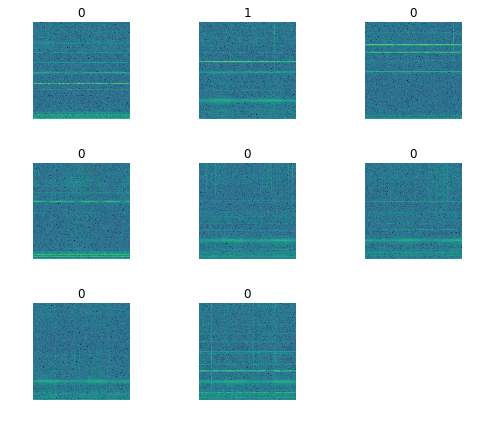

In [41]:
data.show_batch(rows=3, figsize=(7,6))

In [42]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Resnet 34

Resnet50 crashes GPUs

In [54]:
gc.collect()
torch.cuda.empty_cache()

In [55]:
gpu_mem_get_free_no_cache()

10601

In [56]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, callback_fns=[partial(EarlyStoppingCallback, monitor='error_rate', min_delta=0.01, patience=3)])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/walle/.torch/models/resnet34-333f7ec4.pth
87306240it [00:17, 5112855.34it/s]


In [57]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1,2])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


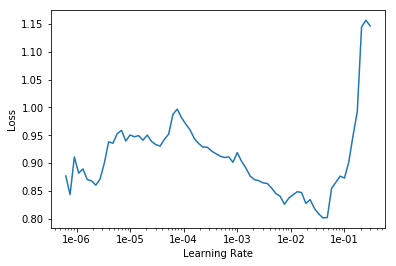

In [58]:
learn.lr_find()
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(cyc_len=5, max_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
1,0.423869,0.414659,0.141866,10:23
2,0.398682,1.083442,0.146820,10:26
3,0.415411,2.001581,0.146325,10:27
4,0.395638,0.964928,0.150287,10:25


Epoch 5: early stopping


AttributeError: 'bool' object has no attribute 'items'

In [50]:
learn.save(f'{MODEL_NAME}_aug_stage-1_rn34_{DATE}')

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-4, 1e-3))

In [ ]:
learn.save(f'{MODEL_NAME}_aug_stage-1-1_rn34_{DATE}')

In [ ]:
#TODO 27/2/2019 submit with this resnet34 model using 10% of good aug
#MODEL_NAME='600_ts_aug_dn_fp16'
#DATE='20190225'
#5 	0.058891 	0.140879 	0.051088


In [46]:
gpu_mem_get_free_no_cache()

10601

In [47]:
gc.collect()
torch.cuda.empty_cache()

In [48]:
gpu_mem_get_free_no_cache()

10601

## Resnet 50

In [43]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, bs=16, suffix='.jpg')

In [44]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [45]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1,2])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


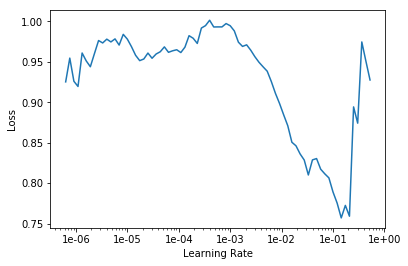

In [59]:
learn.lr_find()
learn.recorder.plot()

<pre>
bs=8
good_aug_smpl = good_aug.sample(frac=1.0)
cyc_len=5, max_lr=3e-3
1 	0.296013 	0.608942 	0.088674 	25:43
2 	0.329495 	12.320765 	0.479895 	25:43
3 	0.301630 	0.707931 	0.094118 	25:40
4 	0.301446 	2.786789 	0.100615 	25:37
5 	0.250486 	3.687357 	0.116301 	25:37

bs=16
frac=1.0
cyc_len=5, max_lr=2e-3
epoch 	train_loss 	valid_loss 	error_rate 	time
1 	0.253808 	0.235641 	0.064442 	20:19
2 	0.214884 	0.236294 	0.067369 	20:12
3 	0.216294 	0.255890 	0.060170 	20:10
4 	0.138307 	0.134522 	0.040211 	20:09
5 	0.107534 	0.130845 	0.042318 	20:10

model name: 600_ts_aug_dn_fp16_aug_stage-1_rn50_20190304.pth
</pre>

In [60]:
learn.fit_one_cycle(cyc_len=5, max_lr=2e-3, callbacks=[SaveModelCallback(learn, every='epoch', monitor='error_rate', name=f'rn50_best_{DATE}')])

epoch,train_loss,valid_loss,error_rate,time
1,0.253808,0.235641,0.064442,20:19
2,0.214884,0.236294,0.067369,20:12
3,0.216294,0.255890,0.060170,20:10
4,0.138307,0.134522,0.040211,20:09
5,0.107534,0.130845,0.042318,20:10


In [61]:
learn.save(f'{MODEL_NAME}_aug_stage-1_rn50_{DATE}')

model name: 600_ts_aug_dn_fp16_aug_stage-1_rn50_20190304.pth

In [63]:
DATE

'20190304'

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
1,0.111537,3.450863,0.242728,20:08
2,0.098148,0.224532,0.086099,20:10
3,0.081554,0.348659,0.093181,20:09


In [ ]:
learn.save(f'{MODEL_NAME}_aug_stage-1-1_rn50_{DATE}')

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
gpu_mem_get_free_no_cache()

## Densenet

Densenet169 too memory intensive for 2x1080ti's

limited to dn121

In [ ]:
from torchvision.models import densenet121
#from torchvision.models import densenet169

In [ ]:
#reduce batch size to 8

In [ ]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, bs=16, suffix='.jpg')

In [ ]:
learn = create_cnn(data, densenet121, metrics=[error_rate])

In [ ]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1,2])

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

In [ ]:
learn.save(f'{MODEL_NAME}_aug_stage-1_dn121_{DATE}')

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

In [ ]:
learn.save(f'{MODEL_NAME}_aug_stage-1-1_dn121_{DATE}')

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.load(f'{MODEL_NAME}_aug_stage-1_dn121_{DATE}')

### unfreeze

In [ ]:
learn.unfreeze()


In [ ]:
learn.lr_find()


In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-5))

In [ ]:
learn.save(f'{MODEL_NAME}_aug_stage-2_dn121_{DATE}')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

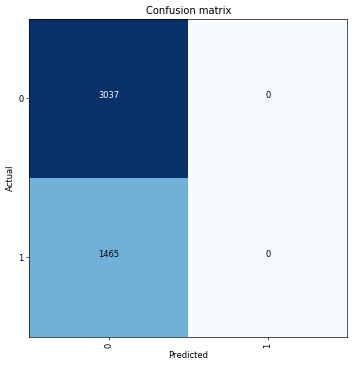

In [83]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Predict

In [46]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [47]:
learn.load(f'{MODEL_NAME}_aug_stage-2_dn121_{DATE}')
#learn.load(f'{MODEL_NAME}_aug_stage-1_rn50_{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList (68343 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
0,0,1,1,1
Path: ../ssd_input/train_600_ts_aug_viridis-70-20;

Valid: LabelList (17085 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
0,0,0,0,0
Path: ../ssd_input/train_600_ts_aug_viridis-70-20;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(6

In [48]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [49]:
df_sub_dn121_u=pd.DataFrame.from_dict(d, orient='index')

In [50]:
df_sub_dn121_u=df_sub_dn121_u.reset_index()


In [51]:
df_sub_dn121_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_dn121_u.head()

,signal_id,target
0,9267,0
1,12535,1
2,27325,0
3,10223,0
4,12016,0


In [53]:
#not actual name for sub 9
df_sub_dn121_u.to_csv(path/f'submissions/submission_{MODEL_NAME}_aug_stage-1_rn50_{DATE}_{UID}.csv', index=False)

In [ ]:
#submission 9 0.3
#worst submission yet !!!
